In [1]:
# Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds


# Imports


1. [RAPIDS CuDF env set up](https://docs.rapids.ai/install)
1. `pip install pdm`
1. `pdm install`
1. Add the following to configuration file (e.g., .bashrc, .zshrc):

```bash
# CUDA
export LD_LIBRARY_PATH="/usr/lib/wsl/lib/"
export NUMBA_CUDA_DRIVER="/usr/lib/wsl/lib/libcuda.so.1"
export LD_LIBRARY_PATH=/usr/local/cuda-11.2/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}

```


In [2]:
import cudf
print(cudf.__version__)

24.06.00


In [3]:
from numba import cuda

try:
    print("Available GPUs:", cuda.gpus)
except cuda.CudaSupportError as e:
    print("CUDA Error:", e)

Available GPUs: <Managed Device 0>


In [4]:
%load_ext cudf.pandas
import os

# for EDA
import wget
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt # https://scikit-plot.readthedocs.io/en/stable/Quickstart.htm
from IPython.display import display

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import ComplementNB

# tuning and metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mutual_info_score

# Deployment
import bentoml

# still need?
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load

#### The Process

**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

### Load

In [77]:
url = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'
path = './data/'

In [78]:
try:
    # Download the file and overwrite if it exists
    if os.path.exists(path):
        os.remove(path)
    wget.download(url, out=path)
    print(f"\nFile downloaded and saved to {path}")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: [Errno 21] Is a directory: './data/'


In [6]:


if not os.path.exists(path):
    os.mkdir(path)
    print('Directory created.')
else:
    print('Directory already exists.')

wget.download(url,out = path)

Directory already exists.


'./data//healthcare-dataset-stroke-data (1).csv'

In [7]:
%%cudf.pandas.profile

df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

                                                                                              
                                  Total time elapsed: 0.536 seconds                           
                                1 GPU function calls in 0.272 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ read_csv │ 1          │ 0.272       │ 0.272       │ 0          │ 0.000       │ 0.000       │
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

# Transform - Exploratory Data Analysis (EDA)

### **Overview**

In [8]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [9]:
df.columns = df.columns.str.lower()

In [10]:
df = df.drop(columns='id')

In [11]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   gender             5110 non-null   object
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64
 3   heart_disease      5110 non-null   int64
 4   ever_married       5110 non-null   object
 5   work_type          5110 non-null   object
 6   residence_type     5110 non-null   object
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object
 10  stroke             5110 non-null   int64
dtypes: float64(3), int64(3), object(5)
memory usage: 495.5+ KB


In [12]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Min age of 0.08, expected whole integers.

# Distribution of all features are all highly positively skewed except for age which is slightly negatively skewed.
# numeric_only=True else error
df.skew(numeric_only=True) 

### **Label Value - df.stroke**

The target value to be predicted is df.stroke. This a a binary feature with 1 to indicate positive for stroke and 0 to indicate not positive for stroke.

In [13]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

High imbalance with a low value count for the positive prediction.

The label data is imbalanced, this is consistent with expectations as more people don't have stroke than do. Further consideration should be done on the negative affect this may have on the models. [Possible solutions](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

In [14]:
stroke_rate = df.stroke.mean() # works because it is binary
round(stroke_rate,2)

0.05

Exact data on stroke prevelance is not avaible but some estimations can be made. From this [report](https://n.neurology.org/content/97/20_Supplement_2/S6) we know that the annual incident for stroke is ~3% in the US. Globally it varies by country economic status, with lower countries often having higher rates (see fig 2 in link). From that we can assume the 5% seen here is roughly representative of the real world stroke incident. 

### **df.age**

<Axes: xlabel='age'>

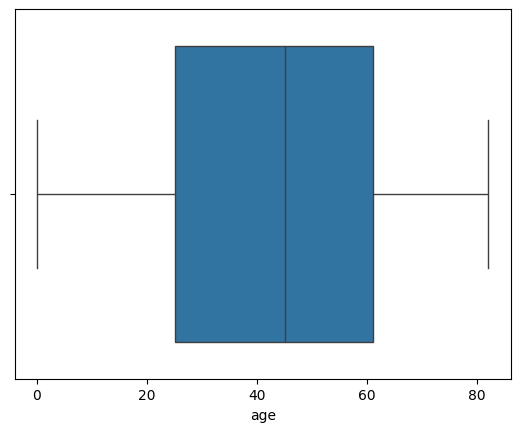

In [15]:
# No outliers in age
sns.boxplot(x=df.age)

<Axes: ylabel='Frequency'>

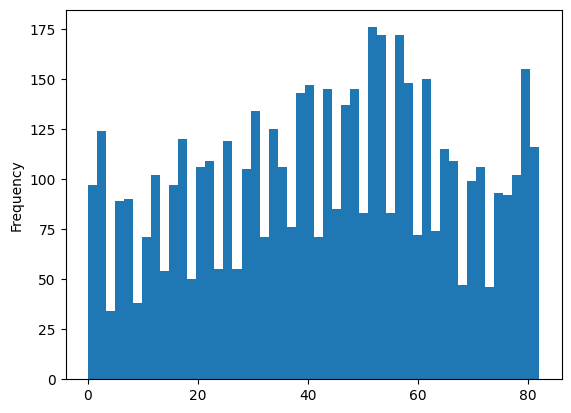

In [16]:
df.age.plot.hist(bins=50)

In [17]:
df.age.value_counts()

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
0.16       3
0.48       3
1.40       3
0.08       2
0.40       2
Name: count, Length: 104, dtype: int64

Clarification on age [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/223242?search=age), decimal places represent days.

### **df.bmi**

###### **Missing values**
[Missing Value Guide](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/)

**Hypothesis**

There is a difference in the stroke grouping and missing values should be filled based on groups of either positive for stroke or not.

In [18]:
# bmi without missing values so that we can apply further analysis
# '~' reverses the bool and the returns the opposite of the bool value specified
bmi = df.bmi[~df['bmi'].isnull()]

In [19]:
# mean of the full sample
full_mean = bmi.mean()
full_mean

28.893236911794666

In [20]:
# 0 not a stroke and 1 is a stroke
stroke_bmi_0, stroke_bmi_1 =df.groupby('stroke')['bmi'].mean()
print('Stroke Negative:',stroke_bmi_0,' ','Stroke Positive:', stroke_bmi_1)

Stroke Negative: 28.82306382978725   Stroke Positive: 30.471291866028718


In [21]:
round((stroke_bmi_1-stroke_bmi_0)/stroke_bmi_1,2)

0.05

A difference of 5% in the bmi mean.

#### **Bootstrapping for Confidence Interval**

[Ditch p-values. Use Bootstrap confidence intervals instead](https://towardsdatascience.com/ditch-p-values-use-bootstrap-confidence-intervals-instead-bba56322b522)

In [22]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)

    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)

    return bs_replicates

In [23]:
bs_replicates_bmi = draw_bs_replicates(bmi,np.mean,15000)
bs_replicates_bmi

array([28.77306987, 28.85589733, 28.74137299, ..., 28.89323691,
       28.92601344, 28.96410674])

In [24]:
# Print BMI mean for stroke positive patients
print("Stroke BMI mean: " + str(stroke_bmi_1))

# Print the mean of bootstrap replicates
bs_mean = np.mean(bs_replicates_bmi)

print(f"Bootstrap replicates mean:"+ str(bs_mean))

Stroke BMI mean: 30.471291866028718
Bootstrap replicates mean:28.894245946900252


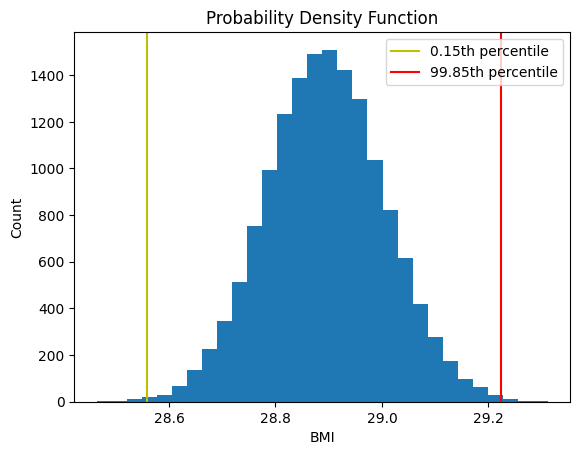

In [25]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_bmi,bins=30)

# Showing the related percentiles
# a = 0.05,this equates to 2.5 on either end of the distribution
plt.axvline(x=np.percentile(bs_replicates_bmi,[0.15]), ymin=0, ymax=1,label='0.15th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_bmi,[99.85]), ymin=0, ymax=1,label='99.85th percentile',c='r')

plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("Probability Density Function")
plt.legend()
plt.show()

In [26]:
# Get the corresponding values of percentiles
conf_interval = np.percentile(bs_replicates_bmi,[99.85])

# Print the interval
print("The upper confidence interval: ",conf_interval)
print("Stroke BMI mean: " + str(stroke_bmi_1))

The upper confidence interval:  [29.22425141]
Stroke BMI mean: 30.471291866028718


The positive for stroke mean is outside our confidence interval. This indicates that with a 99% confidence level, the bmi for stroke positive patients is statistically significant.

###### **Manage Outliers**

[Outliers Guide](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

<Axes: xlabel='bmi'>

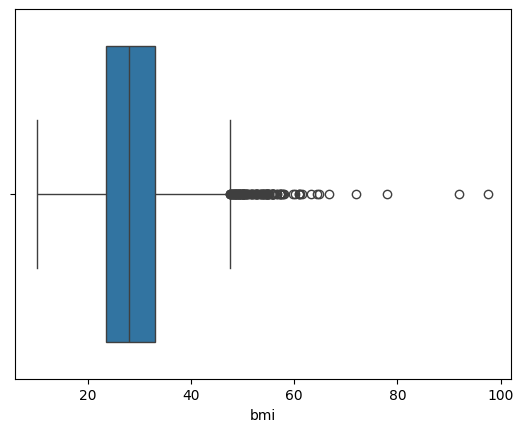

In [27]:
# Outliers noted in df.bmi
sns.boxplot(x=df.bmi)

In [28]:
df.bmi.value_counts(bins=15).sort_values()

bmi
(68.5, 74.32]         1
(74.32, 80.14]        1
(91.78, 97.6]         2
(62.68, 68.5]         4
(56.86, 62.68]       13
(51.04, 56.86]       43
(45.22, 51.04]       86
(10.212, 16.12]     100
(39.4, 45.22]       299
(33.58, 39.4]       690
(16.12, 21.94]      774
(27.76, 33.58]     1395
(21.94, 27.76]     1501
Name: count, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in the dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

Without a height metric, these outliers are assumed to be natural variants in the population.


[BMI](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html)

Managing missing values:
Decision is to fill missing values.

* bmi for stroke positive patients is statistically significant and should be calculated separately for filling NAs.
* Previous iteration (first run of the notebook) shows that using median for each group produces more accurate models than using mean for each group.

In [29]:
bmi_0, bmi_1= df.groupby('stroke')['bmi']

In [30]:
# confirm grouping
bmi_0[0],bmi_1[0]

(0, 1)

In [31]:
bmi_0[1].mean()

28.823063829787234

In [32]:
bmi_1[1].mean()

30.471291866028707

<Axes: >

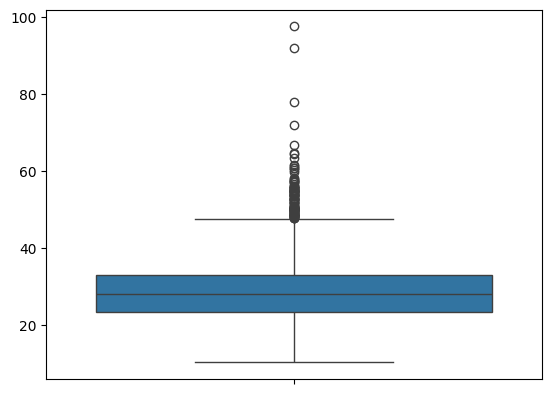

In [33]:
# box plot for bmi stroke negative
bmi_0 = np.array(bmi_0[1])
sns.boxplot(bmi_0)

<Axes: >

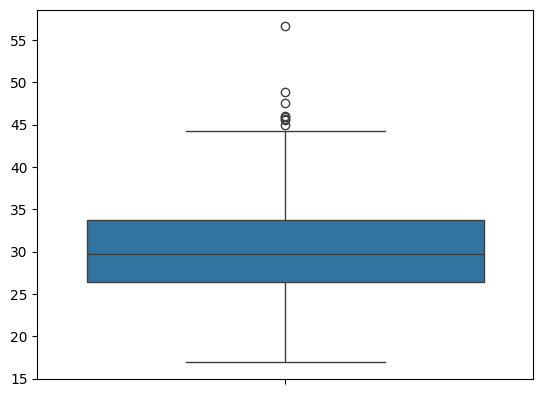

In [34]:
# box plot for bmi stroke possitive
bmi_1 = np.array(bmi_1[1])
sns.boxplot(bmi_1)

In [35]:
# Calculate the median BMI for stroke and non-stroke groups
median_bmi = df.groupby('stroke')['bmi'].median()
median_bmi_0 = median_bmi[0]
median_bmi_1 = median_bmi[1]
print("Median BMI for non-stroke patients:", median_bmi_0)
print("Median BMI for stroke patients:", median_bmi_1)

Median BMI for non-stroke patients: 28.0
Median BMI for stroke patients: 29.7


###### **Fill Missing Values**

In [36]:
# Fill missing BMI values for stroke patients
df.loc[(df['stroke'] == 1) & df['bmi'].isnull(), 'bmi'] = median_bmi_1

# Fill missing BMI values for non-stroke patients
df.loc[(df['stroke'] == 0) & df['bmi'].isnull(), 'bmi'] = median_bmi_0

In [37]:
# Confirm there are no null values in the BMI column
null_counts = df['bmi'].isnull().sum()

if null_counts == 0:
    print("No null values in the BMI column.")
else:
    print(f"There are {null_counts} null values in the BMI column.")


No null values in the BMI column.


In [38]:
df.bmi.describe()

count    5110.000000
mean       28.871409
std         7.699951
min        10.300000
25%        23.800000
50%        28.000000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

###### **Obese Feature**

Obesity is [diagnosed](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html) for people with a bmi of 30 or greater.

I am creating a separate DataFrame (df2) to test generalized features such as obesity vs specific features like BMI.

In [39]:
df2 = df.copy()

In [40]:
df2['obese'] = df2['bmi'] >=30

In [41]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,obese
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,True
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.7,never smoked,1,False
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,True
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,True
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,False


In [42]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.7,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### **df.avg_glucose_level**

##### **Outliers avg_glucose_level**

<Axes: xlabel='avg_glucose_level'>

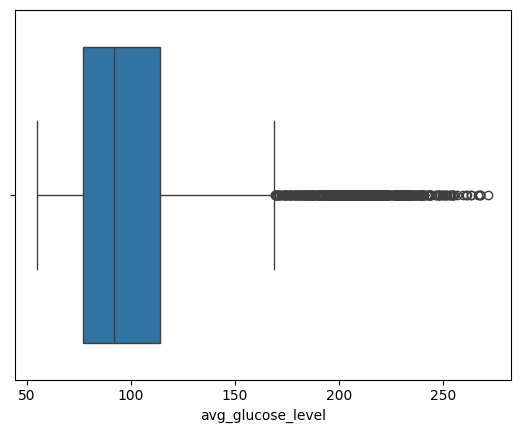

In [43]:
# Outliers noted in df.avg_glucose_level
sns.boxplot(x=df.avg_glucose_level)

In [44]:
df['avg_glucose_level'].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

In [45]:
df.avg_glucose_level.value_counts(bins=15).sort_values()

(257.299, 271.74]       10
(242.857, 257.299]      35
(170.651, 185.092]      61
(156.209, 170.651]      71
(228.416, 242.857]      88
(141.768, 156.209]     113
(185.092, 199.533]     119
(213.975, 228.416]     145
(127.327, 141.768]     150
(199.533, 213.975]     162
(112.885, 127.327]     370
(54.902, 69.561]       728
(98.444, 112.885]      746
(84.003, 98.444]      1142
(69.561, 84.003]      1170
Name: count, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

**Average glucose(a.k.a. blood sugar) level is measured though an A1C or HbA1c test.**

* For a normal person blood sugar can get up to 140 per the [American Diabetes Association](https://diabetesjournals.org/care/article/24/4/775/23438/Postprandial-Blood-Glucose), but diabetes is diagnosed when **AVERAGE** blood sugar is 140 or higher. However, people with Diabetes can get much higher than on this data set. Without a diabetes diagnosis it is not possible to determine if the outliers are inaccurate data. However, it is reasonable to interpet those above 140 as clearly having diabetes.

* Being below 140 does NOT signify someone does not have diabetes. They may simply be well controlled. Most type one diabetics aim for an average blood sugar of 140, while type two aim to be below that level.

* Prediabese determination is beyond the scope of this dataset.

##### **avg_glucose_level stroke comparison**

Reseach shows that Categorizing to above and below a bloodsugar limit may improve predictions.

 [Cleavland Clinic](https://my.clevelandclinic.org/health/diseases/9812-diabetes-and-stroke#:~:text=Your%20body%20can't%20make,Extra%20body%20weight.), [AHA Journal](https://www.ahajournals.org/doi/full/10.1161/01.str.0000115297.92132.84), [stroke.org.uk](https://www.stroke.org.uk/what-is-stroke/are-you-at-risk-of-stroke/diabetes), [Stroke.org - Diabetes](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention).

In [46]:
stroke_glucose_0, stroke_glucose_1 =df.groupby('stroke')['avg_glucose_level'].mean()
stroke_glucose_0, stroke_glucose_1 # 0 not a stroke and 1 is a stroke

(104.7955132688746, 132.54473895582322)

In [47]:
round((stroke_glucose_1-stroke_glucose_0)/stroke_glucose_1,2)

0.21

A 21% difference in the mean of avg_glucose_level of for stroke patients vs non-stroke.

In [48]:
stroke_gluc_0, stroke_gluc_1 =df.groupby('stroke')['avg_glucose_level']

In [49]:
# stroke negative
stroke_gluc_0[1].describe()

count    4861.000000
mean      104.795513
std        43.846069
min        55.120000
25%        77.120000
50%        91.470000
75%       112.830000
max       267.760000
Name: avg_glucose_level, dtype: float64

In [50]:
# stroke positive
stroke_gluc_1[1].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

#### **Bootstrapping**

In [51]:
gluc = df['avg_glucose_level']

In [52]:
bs_replicates_gluc = draw_bs_replicates(gluc,np.mean,15000)

In [53]:
# Print empirical mean
print("Stroke avg_glucose_level mean: " + str(stroke_glucose_1))

# Print the mean of bootstrap replicates
bs_gluc_mean = np.mean(bs_replicates_gluc)

print(f"Bootstrap replicates mean:"+ str(bs_gluc_mean))

Stroke avg_glucose_level mean: 132.54473895582322
Bootstrap replicates mean:106.14375030554467


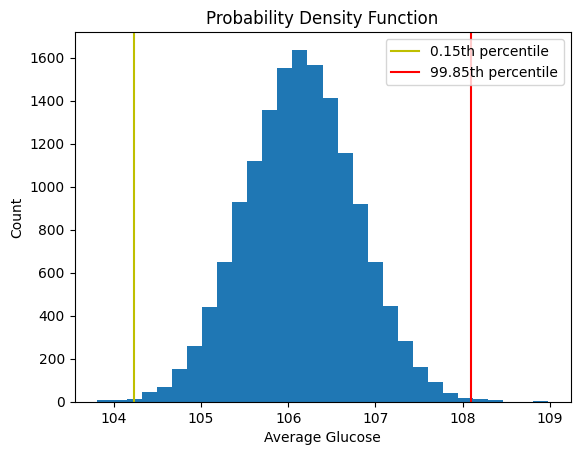

In [54]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(bs_replicates_gluc,bins=30)

# Showing the related percentiles
plt.axvline(x=np.percentile(bs_replicates_gluc,[0.15]), ymin=0, ymax=1,label='0.15th percentile',c='y')
plt.axvline(x=np.percentile(bs_replicates_gluc,[99.85]), ymin=0, ymax=1,label='99.85th percentile',c='r')

plt.xlabel("Average Glucose")
plt.ylabel("Count")
plt.title("Probability Density Function")
plt.legend()
plt.show()

In [55]:
# Get the corresponding values of percentiles
conf_interval = np.percentile(bs_replicates_gluc,[99.85])

# Print the interval
print("The confidence interval: ",conf_interval)
print("Stroke avg_glucose_level mean: " + str(stroke_glucose_1))

The confidence interval:  [108.0955178]
Stroke avg_glucose_level mean: 132.54473895582322


The diference between avg_glucose_level in stroke and non-stroke is statistically signifigant. The higher levels in one classification over another may justify creating a feature to identify those that would be diagnossed as diabetic based on their average glucose level. This does not neccessarily mean the others are not or were not, just identifies those that clearly are.

##### **Clearly Diabetes**

In [56]:
df2['diabetes'] = df['avg_glucose_level'] >= 140

In [57]:
df2['diabetes'].value_counts()

diabetes
False    4289
True      821
Name: count, dtype: int64

In [58]:
df2.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,obese,diabetes
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,True,True


In [59]:
df.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1


### **df.gender**

In [60]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

A single non binary gender is not useful. It is unclear if this is how someone identified or if it was an error. It is best to drop it.

In [61]:
other = df[(df['gender']=='Other')].index
df = df.drop(other)
df2 = df2.drop(other)

In [62]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [63]:
df2.gender.value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

### **Other features**

In [64]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1756
Name: count, dtype: int64

In [65]:
df.work_type.value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [66]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [67]:
df.residence_type.value_counts()

residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

### **Final Feature Overview**

In [68]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   gender             5109 non-null   object
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64
 3   heart_disease      5109 non-null   int64
 4   ever_married       5109 non-null   object
 5   work_type          5109 non-null   object
 6   residence_type     5109 non-null   object
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object
 10  stroke             5109 non-null   int64
dtypes: float64(3), int64(3), object(5)
memory usage: 534.6+ KB


In [69]:
df2.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   gender             5109 non-null   object
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64
 3   heart_disease      5109 non-null   int64
 4   ever_married       5109 non-null   object
 5   work_type          5109 non-null   object
 6   residence_type     5109 non-null   object
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object
 10  stroke             5109 non-null   int64
 11  obese              5109 non-null   bool
 12  diabetes           5109 non-null   bool
dtypes: bool(2), float64(3), int64(3), object(5)
memory usage: 544.6+ KB


In [70]:
df_dummies = pd.get_dummies(df)
df2_dummies = pd.get_dummies(df2)

#### **Review of inter-feature correlation and Data skew**

In [71]:
from scipy.stats import pearsonr

def pValue_corr(df, numeric_only=True):
    # Calculate Pearson correlation coefficients
    corr_matrix = df.corr(numeric_only=numeric_only)

    # Calculate the p-values using scipy's pearsonr
    pvalue_matrix = df.corr(method=lambda x, y: pearsonr(x, y)[1])

    # Create a mask to hide the upper triangle (optional)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Correlation heatmap
    plt.subplots(figsize=(20,16))
    mask = np.triu(np.ones_like(df.corr())) # triangle mask to hide duplicates
    sns.heatmap(df.corr(),cmap="coolwarm", annot=True, mask=mask)
    plt.title("Correlation Heatmap")

    # P-values heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(pvalue_matrix, annot=True, fmt=".4f", cmap="coolwarm", mask=mask, square=True)
    plt.title("P-Value Heatmap")
    plt.show()

##### **correlation matrix**

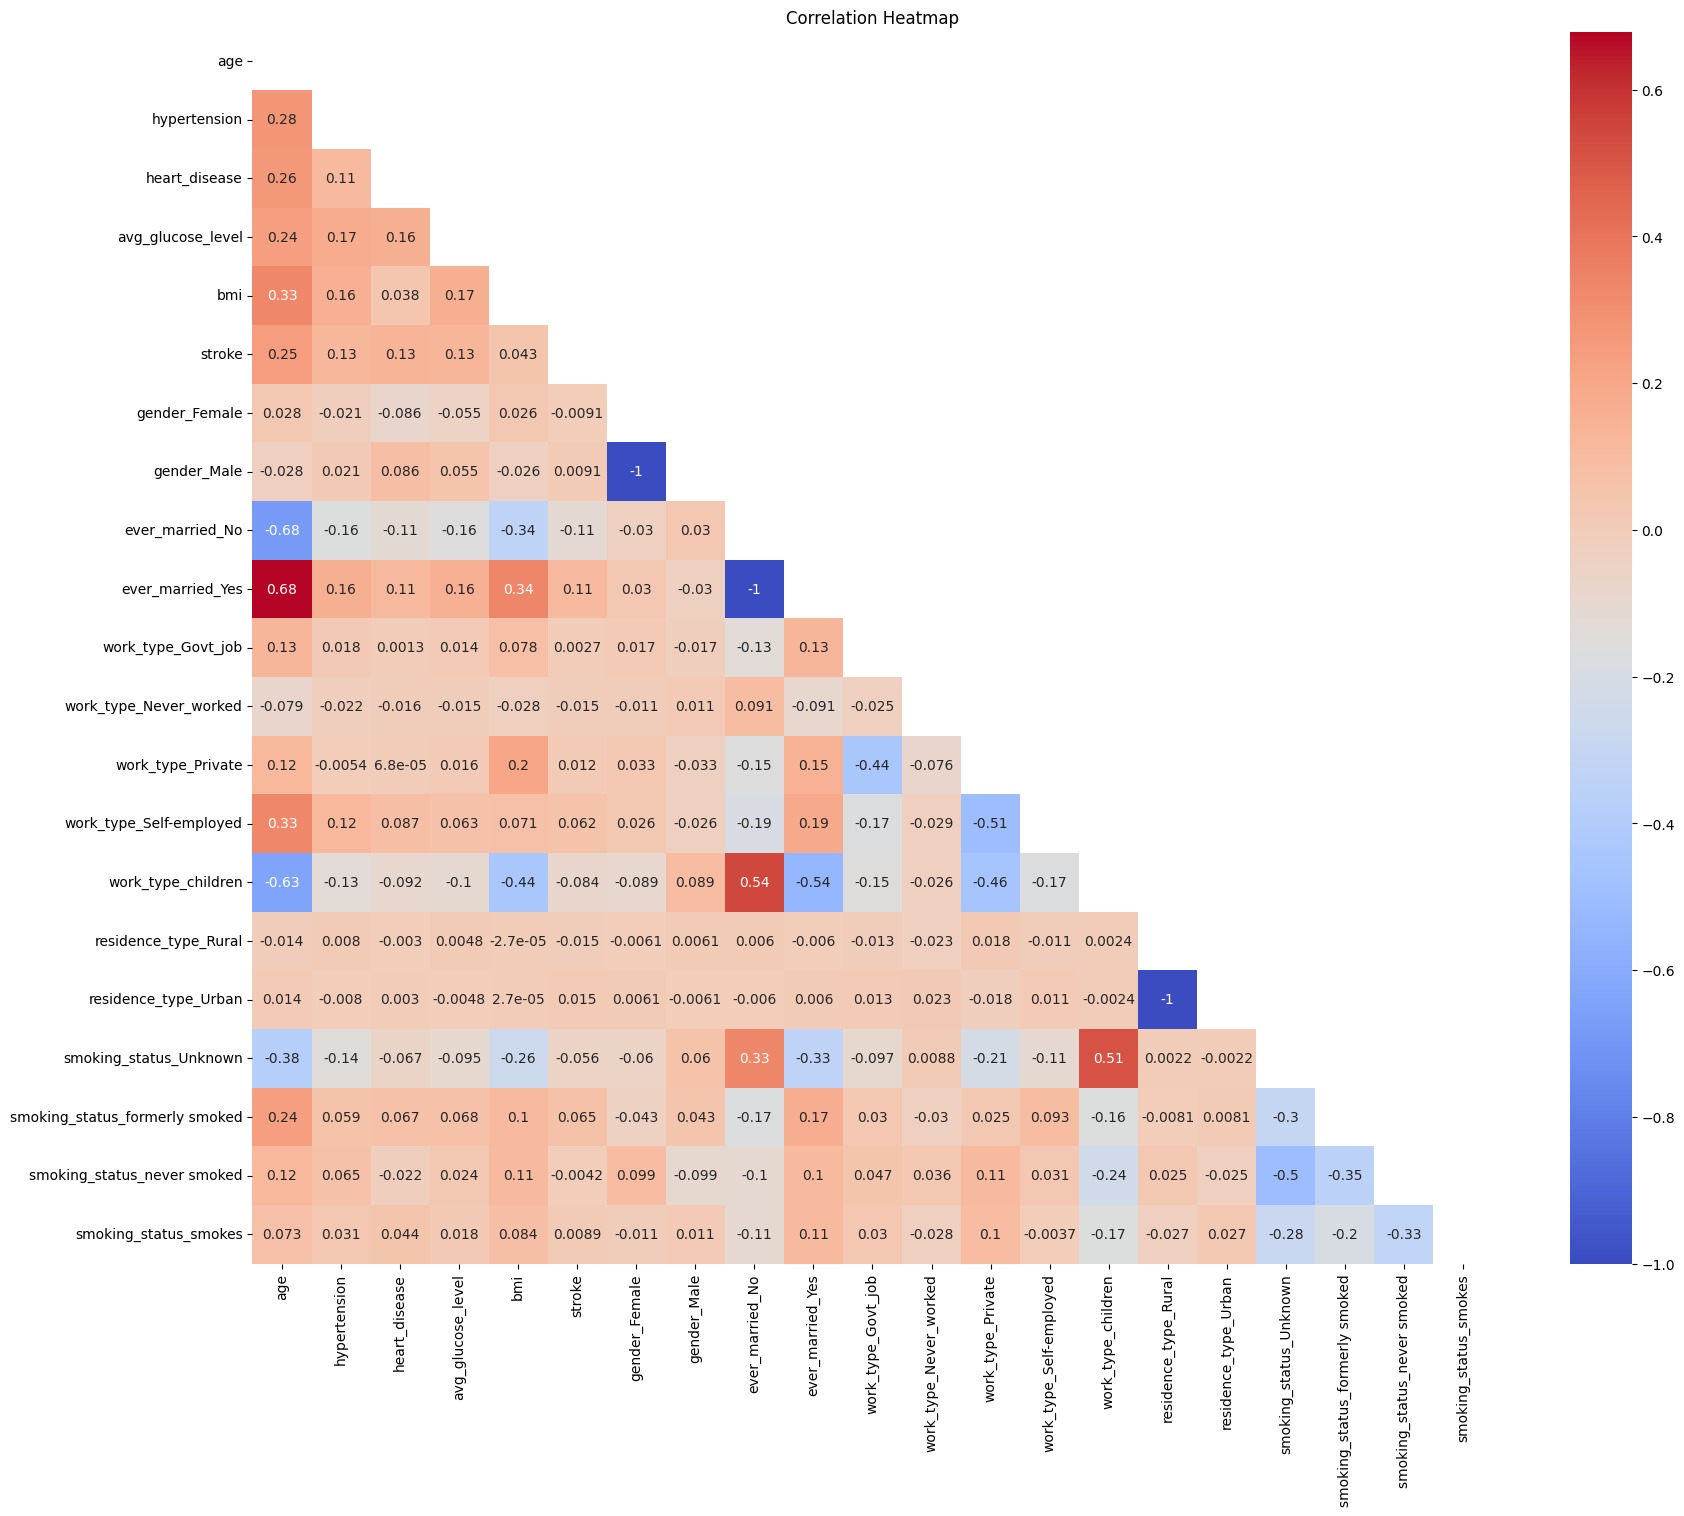

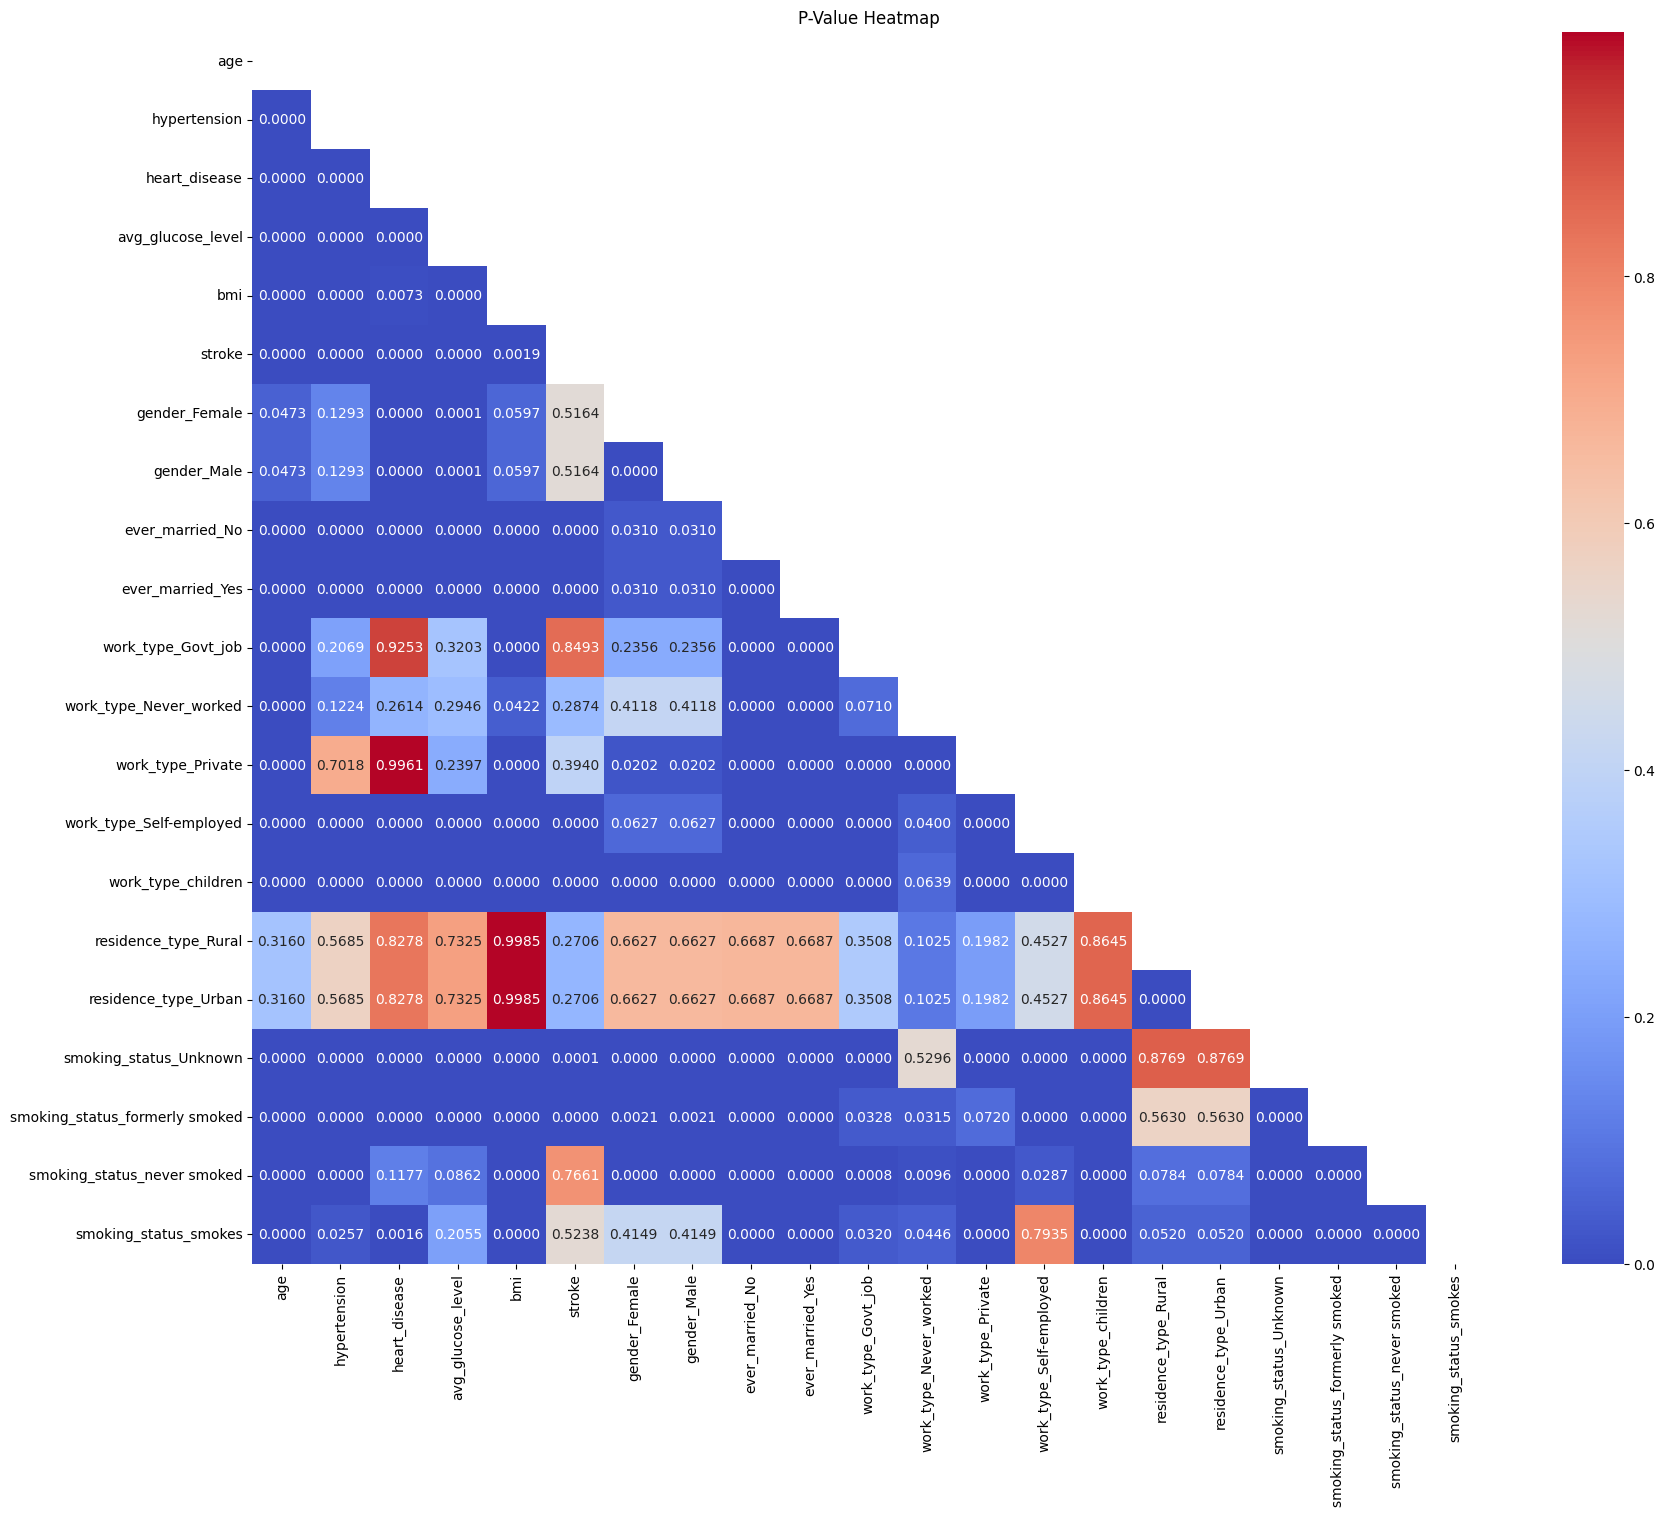

In [72]:
pValue_corr(df_dummies)

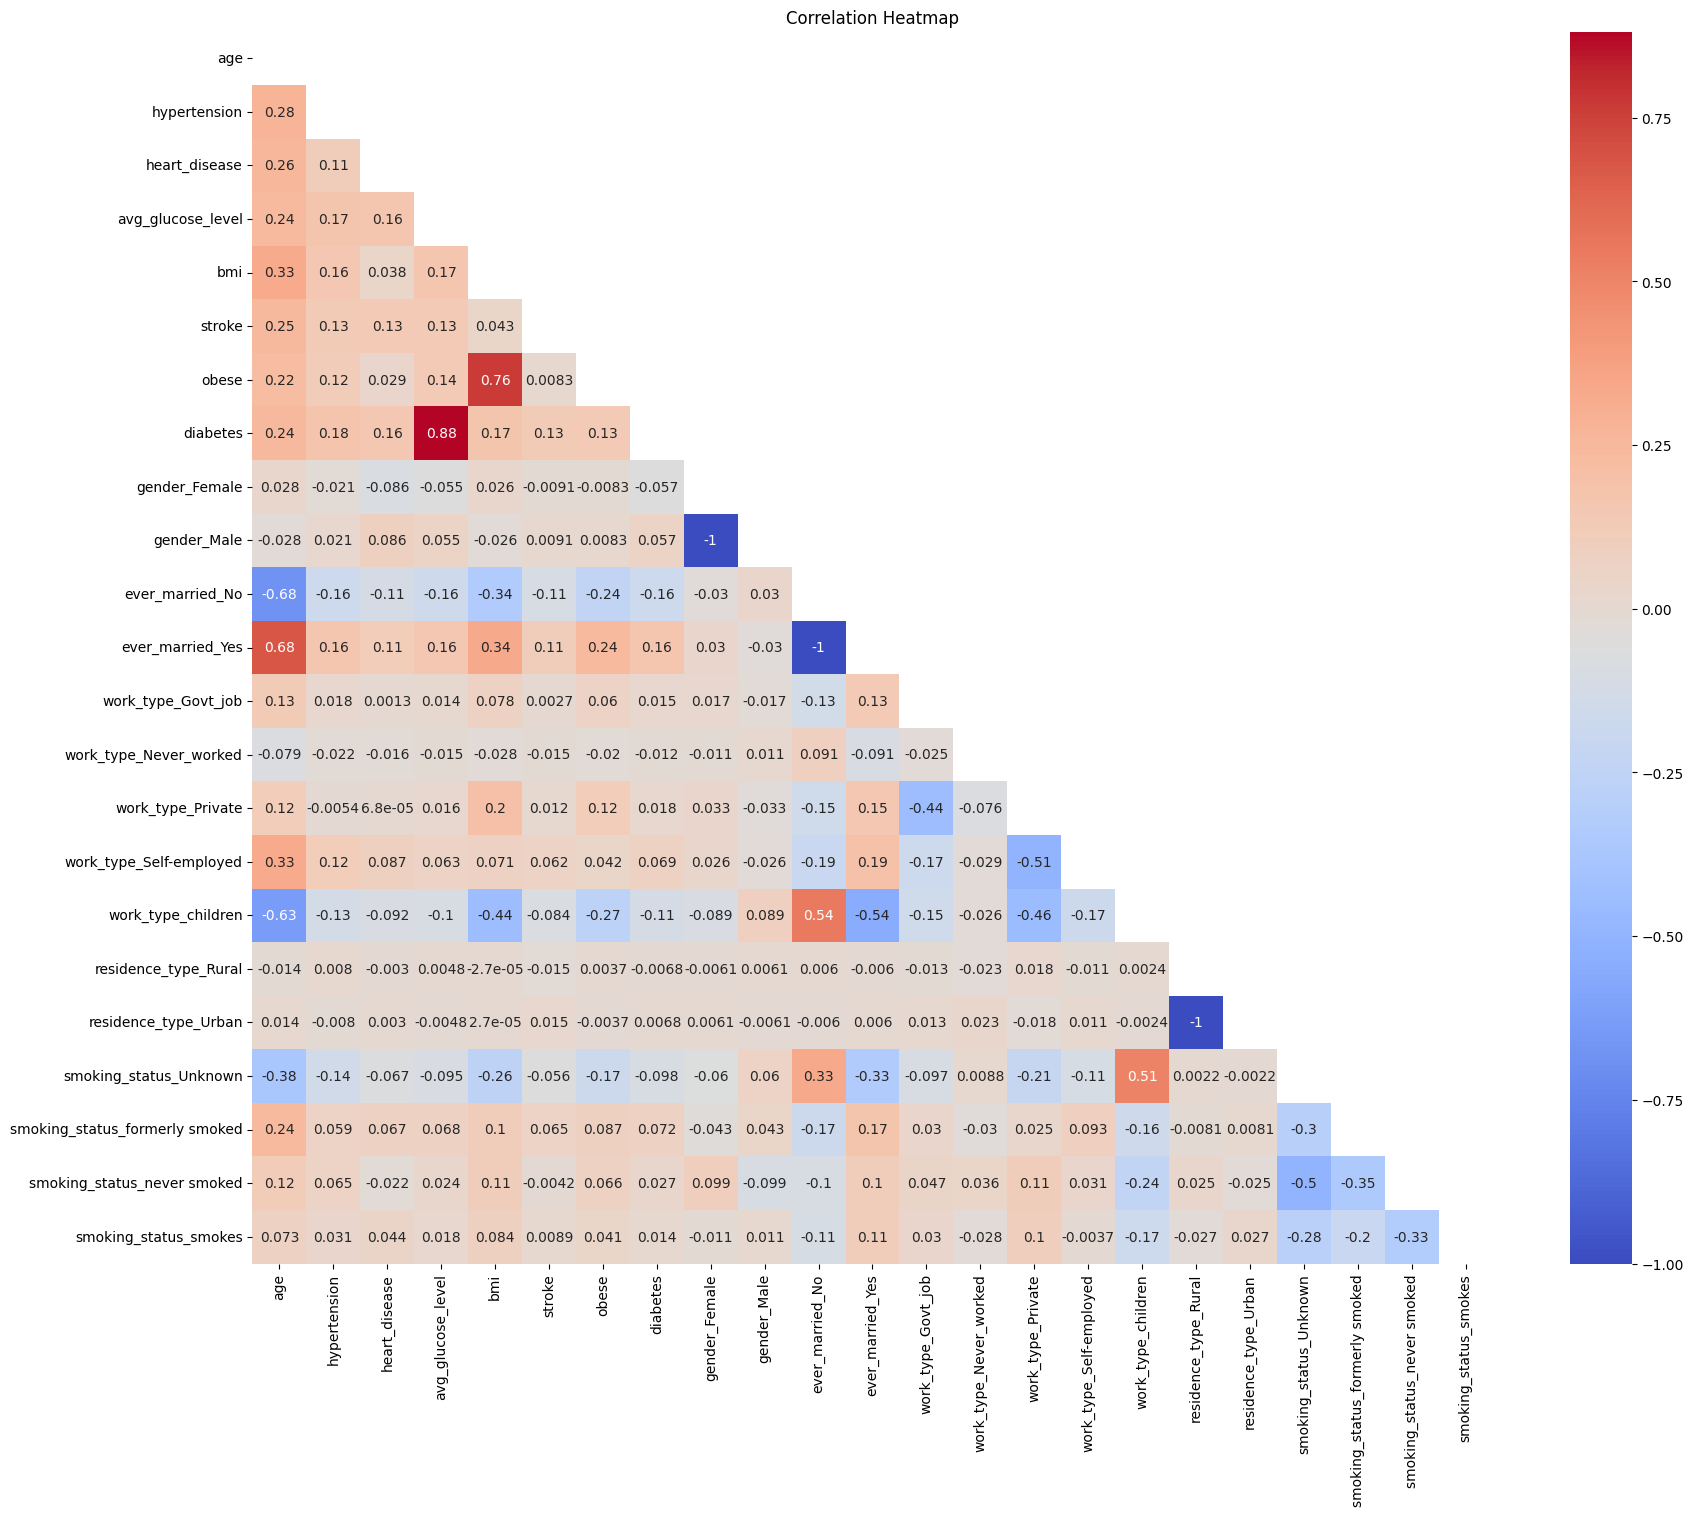

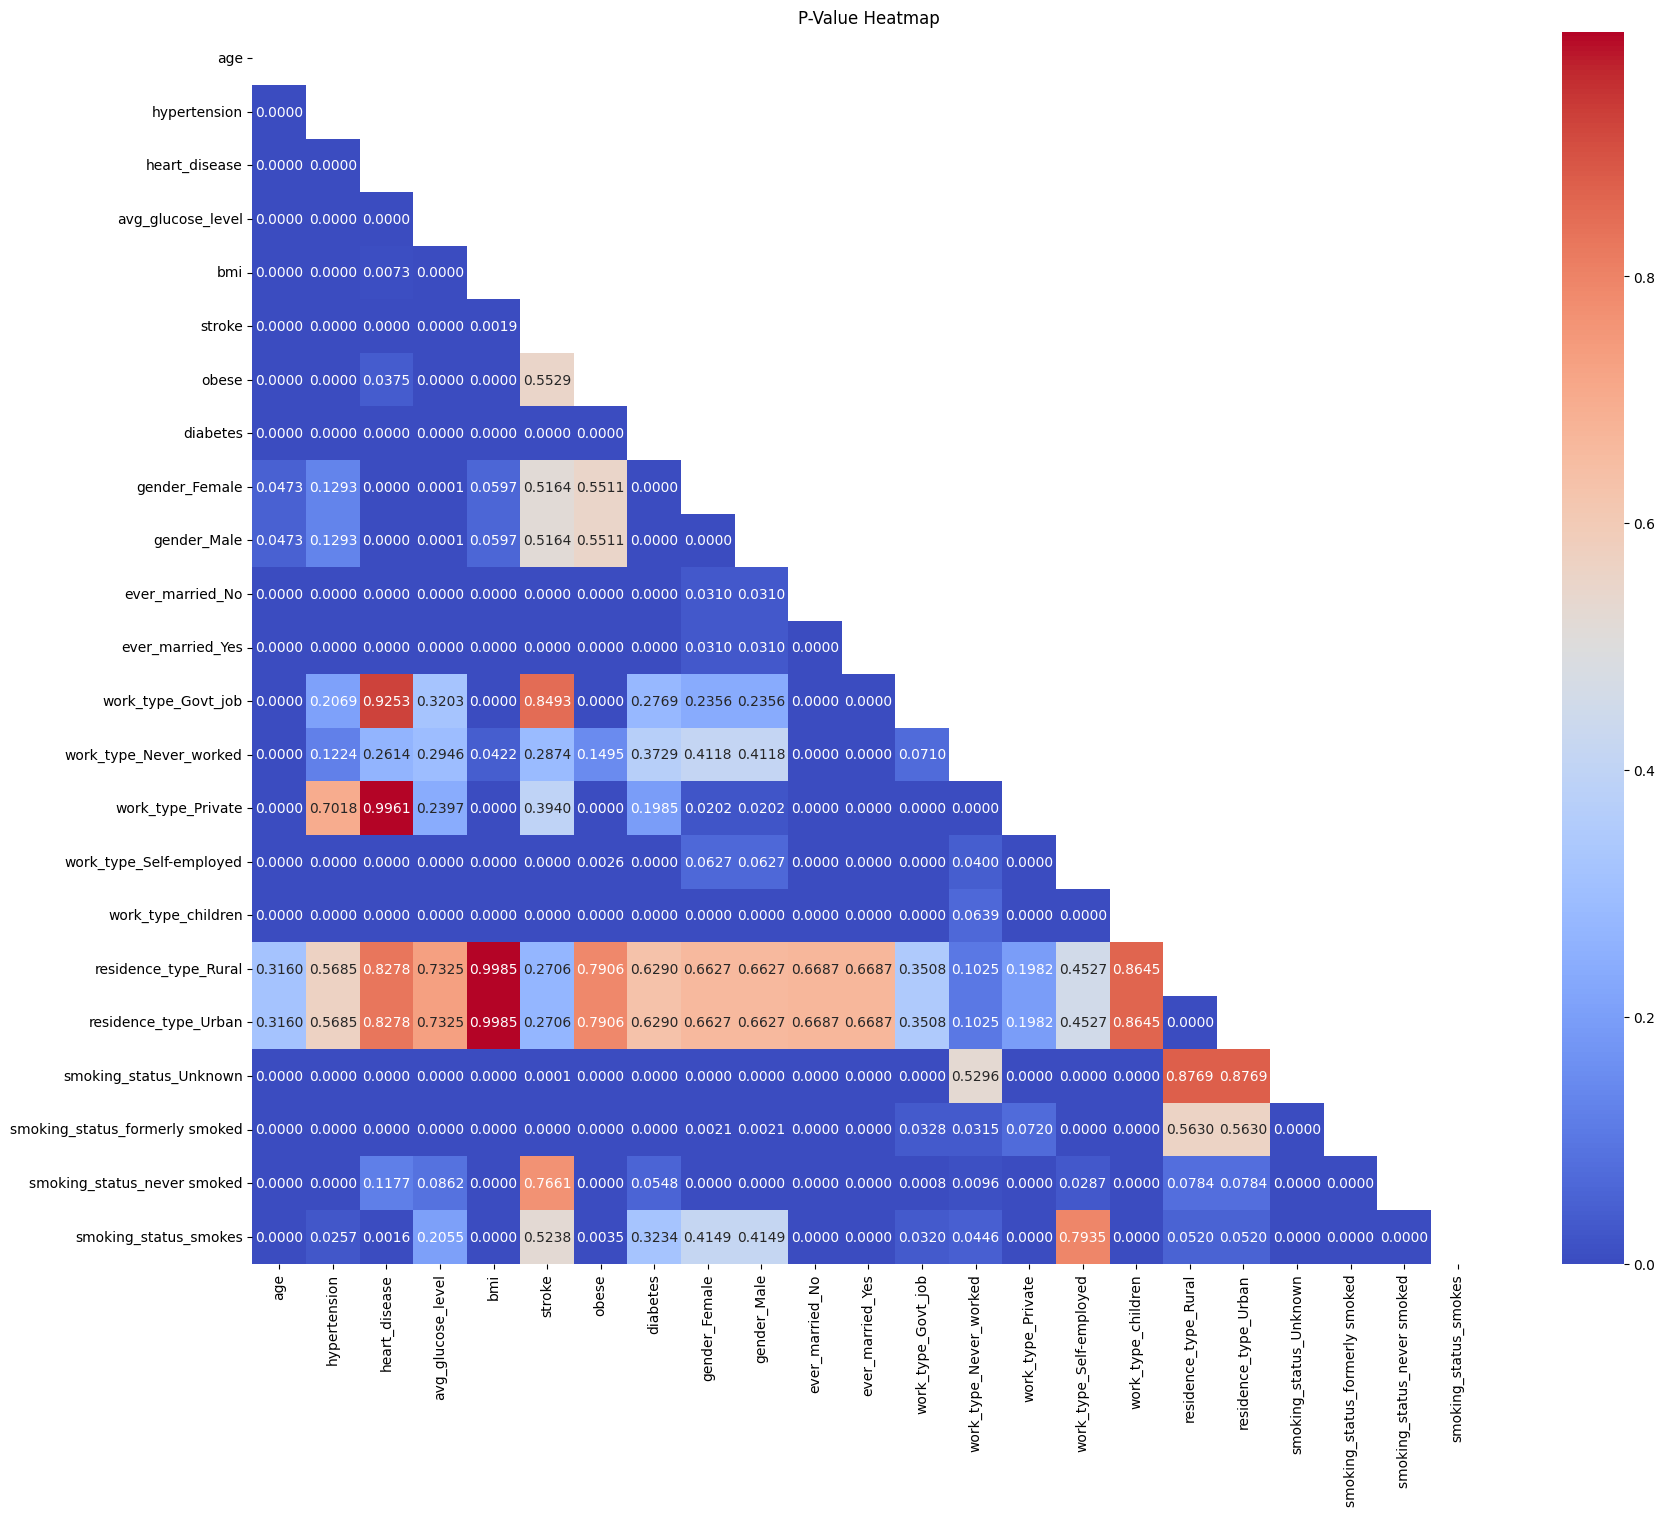

In [73]:
pValue_corr(df2_dummies)

##### **Data Skew**

In [74]:
df_dummies.skew().sort_values(ascending=False)

work_type_Never_worked            15.144843
stroke                             4.192807
heart_disease                      3.946786
hypertension                       2.715026
work_type_Govt_job                 2.219622
work_type_children                 2.143534
smoking_status_smokes              1.913132
work_type_Self-employed            1.852301
smoking_status_formerly smoked     1.729277
avg_glucose_level                  1.572815
bmi                                1.084114
smoking_status_Unknown             0.861669
ever_married_No                    0.658345
smoking_status_never smoked        0.537226
gender_Male                        0.349410
residence_type_Rural               0.032506
residence_type_Urban              -0.032506
age                               -0.137430
work_type_Private                 -0.292454
gender_Female                     -0.349410
ever_married_Yes                  -0.658345
dtype: float64

In [75]:
df2_dummies.skew().sort_values(ascending=False)

work_type_Never_worked            15.144843
stroke                             4.192807
heart_disease                      3.946786
hypertension                       2.715026
work_type_Govt_job                 2.219622
work_type_children                 2.143534
smoking_status_smokes              1.913132
work_type_Self-employed            1.852301
diabetes                           1.850320
smoking_status_formerly smoked     1.729277
avg_glucose_level                  1.572815
bmi                                1.084114
smoking_status_Unknown             0.861669
ever_married_No                    0.658345
smoking_status_never smoked        0.537226
obese                              0.512993
gender_Male                        0.349410
residence_type_Rural               0.032506
residence_type_Urban              -0.032506
age                               -0.137430
work_type_Private                 -0.292454
gender_Female                     -0.349410
ever_married_Yes                

Much of the data is far from a Gaussian (normal) distribution. This may negatively affect model performance and should be reviewed for improving the moel later. Also consider [Your Dataset Is Imbalanced? Do Nothing!](https://towardsdatascience.com/your-dataset-is-imbalanced-do-nothing-abf6a0049813)

In [76]:
df.to_csv('./data/df-healthcare-dataset-stroke-data-df.csv', index=False)
df2.to_csv('./data/df2-healthcare-dataset-stroke-data-df2.csv', index=False)